# Extracting an Emission Surface

In this notebook, we'll walk through how you can extract an emission surface from an image cube following the method presented in [Pinte et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...609A..47P/abstract). For this example, we'll use the DSHARP $^{12}$CO J=2-1 data for the disk around HD 163296, presented in [Isella et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..49I/abstract) and available from the [DSHARP website](https://almascience.eso.org/almadata/lp/DSHARP/), or using the following bit of code. Note that this is a bit of a chunky file (~1.6GB), so make sure you have space for it!

In [1]:
import os
if not os.path.exists('HD163296_CO.fits'):
    from wget import download
    download('https://almascience.eso.org/almadata/lp/DSHARP/images/HD163296_CO.fits')

First, we start off with the standard imports.

In [2]:
from disksurf import observation
import matplotlib.pyplot as plt
import numpy as np

Now we want to load up the data: simply point `observation` to the FITS cube we want to use. If the cube is large (as is the case for the DSHARP dataset), you can provide a field of view, `FOV` in arcsecs, and a velocity range, `velocity_range` in ${\rm m\,s^{-1}}$, which will cut down the data array to only the region you're interested in. This can save a lot of computational time later on.

In [3]:
cube = observation('HD163296_CO.fits', FOV=10.0, velocity_range=[0.0, 12e3])

With these commands, we cut out a region that is $\pm 5^{\prime\prime}$ around the image center, and taking channels between $0~{\rm km\,s^{-1}}$ and  $+12~{\rm km\,s^{-1}}$.

Although we've already cut down the velocity range through the `velocity_range` argument when we loaded up the data, it's better to select only a channel range where we can easily see some difference in the emission height. To get a quick idea of emission structure, we can plot all channel maps.

**WARNING** - If you have a cube with many channels (> 100), this can take a long time!

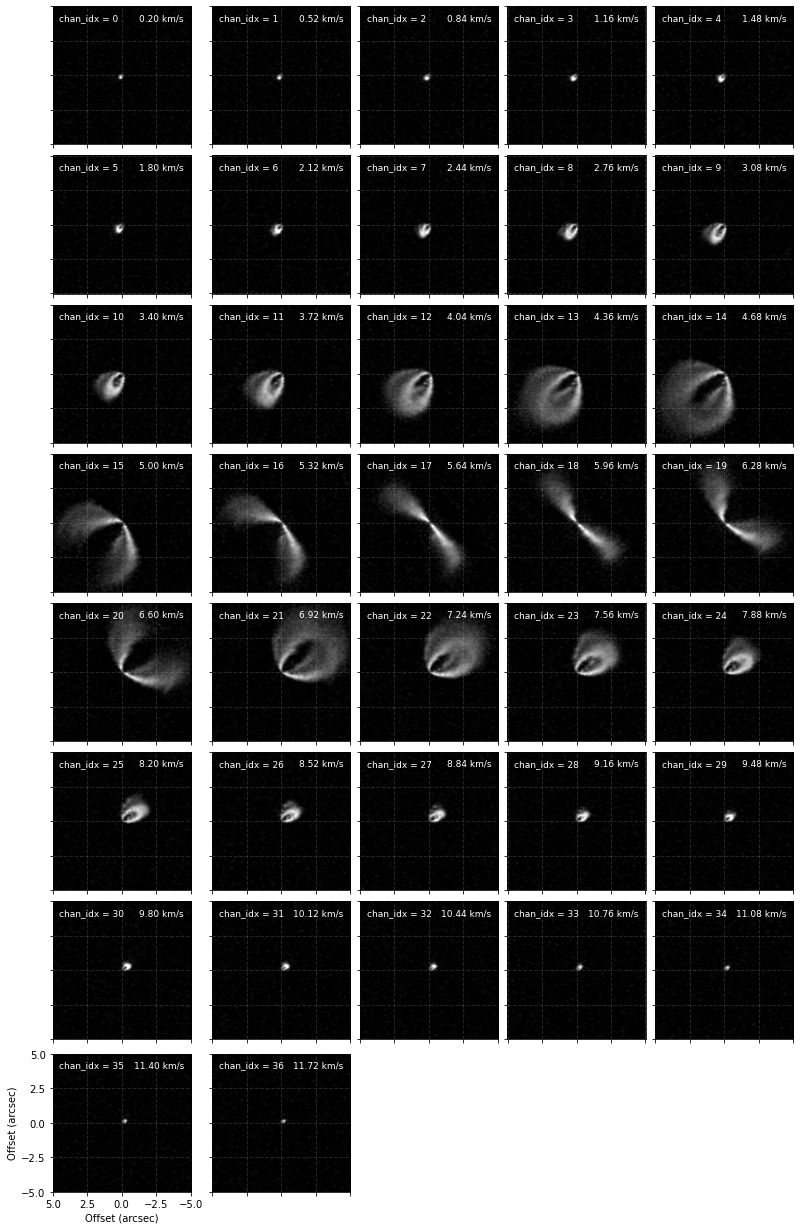

In [4]:
cube.plot_channels()

From these we can see that between channels `9` and `25` we can really nicely distinguish the front and back sides of the disk and would be the best channels to include for the fitting. However, in the central channels around the systemic velocity of $5.7~{\rm km\,s^{-1}}$ the back side is hidden behind the front side so we'd like to avoid those. Instead of just provide a minimum and maximum channel range, e.g., `chans=(9, 25)`, we can provide a list of min/max channel tuples:

In [5]:
chans = [(9, 15), (19, 25)]

This will include channels between 9 and 15 and then again from 19 to 25.

We also want some idea of the geometry of the system, namely the inclination, `inc` in degrees, and position angle, `PA` in degrees of the disk. Adopting those from fits of the continuum emission are usually just fine here, but there are two things to take note of.

* In both `disksurf` and the `GoFish` package on which it is built, the inclination is defined from $-90^{o}$ to $+90^{o}$, with positive inclinations representing a disk that is rotating in a clockwise direction, while a negative inclination describes a disk rotating in a counter-clockwise direction. The `GoFish` documentation shows [a nice example](https://fishing.readthedocs.io/en/latest/user/fishing_coordinates.html#3.-Disk-Rotation-And-Total-Orientation) of how these disks may look.


* Again, in both `disksurf` and `GoFish`, the position angle is measured to the red-shifted major axis of the disk in an anticlockwise direction from North. This may result in a $\pm 180^{o}$ difference from those derived from fits to the continuum.

We also want to specify any offset of the source center relative to the image center with `(x0, y0)` in units of arcsecs. If the image has been centered, then these should be zero. We take these offsets from the continuum fitting described in [Huang et al. (2018; DSHARP II)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..42H/abstract).

Finally we need the systemic velocity, `vlsr`, in meters per second.

In [6]:
x0 = -2.8e-3 # arcsec
y0 = 7.7e-3  # arcsec
inc = 46.7   # deg
PA = 312.0   # deg
vlsr = 5.7e3 # m/s

With these values to hand, we can apply the emission surface extraction method to the entire data cube with the `get_emission_surface` function. This will return a `surface` class which contains the extracted emission surface. It will have contain arrays of the radial and vertical coordinates, `r` and `z` in arcsecs, the emission intensity at that point, `I`, in ${\rm Jy~beam^{-1}}$ (also converted to a brightness temperature, `T`, using the full Planck law) and the velocity of the channel that this point was extracted from, `v` in ${\rm m\,s^{-1}}$.

When calling this we also include a `smooth=1.0` argument. This will convolve each vertical column with a Gaussian kernel with a FWHM that is `smooth` times the beam major FWHM. This is useful to remove some of the noise in the data. Some data may require more smoothing than others and will probably require some playing around to find the best value.

In [7]:
surface = cube.get_emission_surface(x0=x0, y0=y0, inc=inc, PA=PA,
                                    vlsr=vlsr, chans=chans, smooth=1.0)

Centering data cube...
Rotating data cube...
Detecting peaks...
Done!


---
**Keplerian Masking** - For some cases, particularly those with low signal-to-noise emission, it can be helpful to apply a Keplerian mask to the data to help limit where peaks are found. This can be included in the call to `get_emission_surface` through a dictionary passed as `keplerian_mask_kwargs`. In addition to the parameters required by `get_emission_surface` you will additionally need to provide the stellar mass, `mstar`, in solar masses, the systemic velocity, `vlsr`, in ${\rm m\,s^{-1}}$, and the distance, `dist`, to the source in parsec. More details can be found in the `keplerian_mask` docstring.

A similar dictionary can also be passed to `plot_channels` to overlay where the mask would run to verify that the parameters that you have chosen are reasonable.

---

A quick way to see your extracted surface is with the `plot_surface` function.

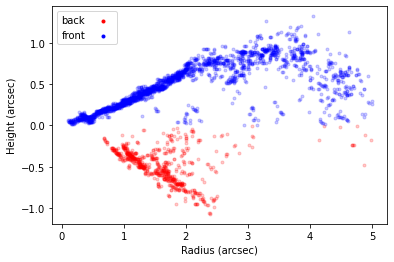

In [8]:
surface.plot_surface()

This will plot all the extracted points, with the 'front' side of the disk shown in blue and the 'back' side of the disk in red. In the inner region of the disk, within $2^{\prime\prime}$ we see we are able to well recover both sides of the disk. However, in the outer disk we see that the 'front' and 'back' side are overlapping. This is because we no longer have four distinct peaks (two for each surface), but just two, as the two sides are no longer spatially resolved.

To better see this, we can use this extracted `surface` to plot where the peaks were found.

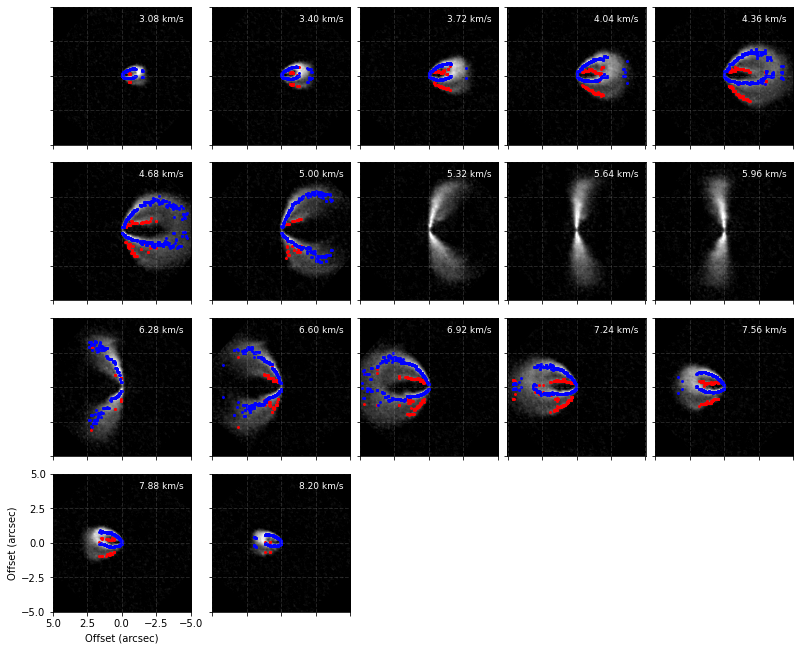

In [9]:
cube.plot_peaks(surface=surface)

Note here that the channels around the systemic velocity are skipped because of how we specified `chans`.

We can now use our physical intuition to remove some of these noisy points. The most straightforward and easy-to-defend cut is simply making cuts in $z \, / \, r$:  we know that the aspect ratio of the disk can't be greater than one (at least in most cases), and it shouldn't be negative. We can use the `mask_surface` function to apply these cuts to the `zr` attribute.

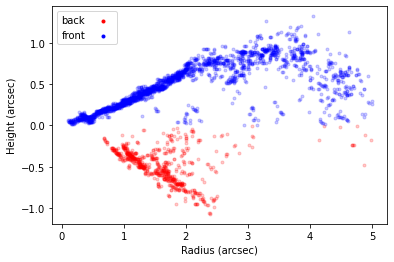

In [10]:
surface.mask_surface(side='both', min_zr=0.0, max_zr=1.0, reflect=True)
surface.plot_surface()

In the above example we've also specified `side='both'` to apply the mask to both sides of the disk (alternatively, we can set `side='front'` or `side='back'` to mask each side separately). We've also included `reflect=True` which will reflect the back side of the disk about the disk midplane for the case of masking, meaning that you can more easily apply the same mask. If we wanted to do this to each separately we could write:

```python
surface.mask_surface(side='front', min_zr=0.0, max_zr=1.0)
surface.mask_surface(side='back', min_zr=-1.0, max_zr=0.0)
```

In addition to geometrical cuts, we make a signal-to-noise cut. Let's remove all points where the SNR is less than 10. By default the RMS is calculated as the RMS of the pixels in the first 5 and last 5 channels using the `estimate_RMS` function (this result is stored in the `surface.rms` attribute). If you would like to provide a different RMS value you can use the `RMS` value in mask_surface. 

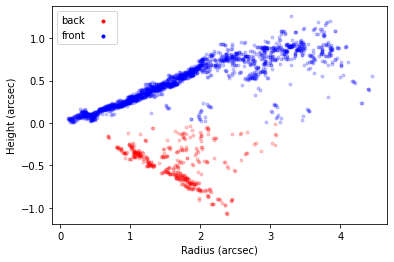

In [11]:
surface.mask_surface(side='both', min_SNR=10.0)
surface.plot_surface()

**NOTE** - At any point you can use `surface.reset_mask()` to rest the masking you've applied. Most functions also accept the `masked` argument which, if set to `False` will use the unmasked points instead.

We can now see that this masking has removed some of those pesky points when plotting the peaks.

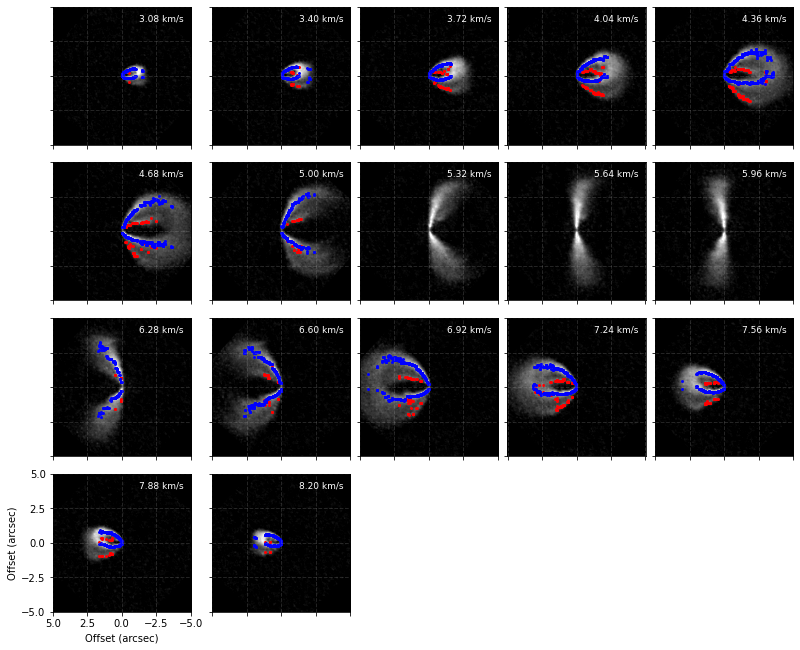

In [12]:
cube.plot_peaks(surface=surface)

Now that we're happy with the surface, we can extract it to use it in other functions. Two functions provide this sort of functionality: `surface.binned_surface`, which will return the emission surface binned onto a radial grid, and `surface.rolling_surface` which will return the rolling average.

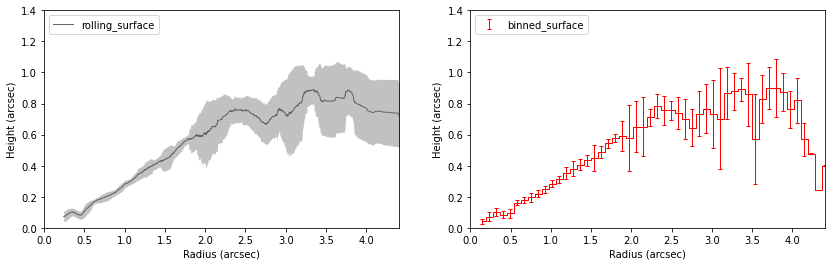

In [13]:
fig, [ax1, ax2] = plt.subplots(figsize=(14, 4), ncols=2)  

r, z, dz = surface.rolling_surface()
ax1.fill_between(r, z - dz, z + dz, lw=0.0, color='0.4', alpha=0.4) 
ax1.plot(r, z, lw=1.0, color='0.4', label='rolling_surface') 

r, z, dz = surface.binned_surface()
ax2.step(r, z, where='mid', c='r', lw=1.0)
ax2.errorbar(r, z, yerr=dz, c='r', lw=1.0, capsize=2.0,
             capthick=1.0, fmt=' ', label='binned_surface')

for ax in fig.axes:
    ax.legend(loc=2)
    ax.set_xlim(0, r.max())
    ax.set_ylim(0, 1.4)
    ax.set_xlabel('Radius (arcsec)')
    ax.set_ylabel('Height (arcsec)')

Note that these are both wrappers for the functions `surface.binned_parameter` and `surface.rolling_parameter` which will radially bin or calculate the rolling average for a specific parameter, such as the height, intensity or brightness temperature.

We can also use this surface to plot isovelocity contours on our channel maps and see how they fare. For this, we need to provide information about the velocity field, namely the stellar mass in units of $M_{\odot}$, `mstar`, the distance to the source in parsecs, `dist`, and the systemic velocity in ${\rm m\,s^{-1}}$, `vlsr`.

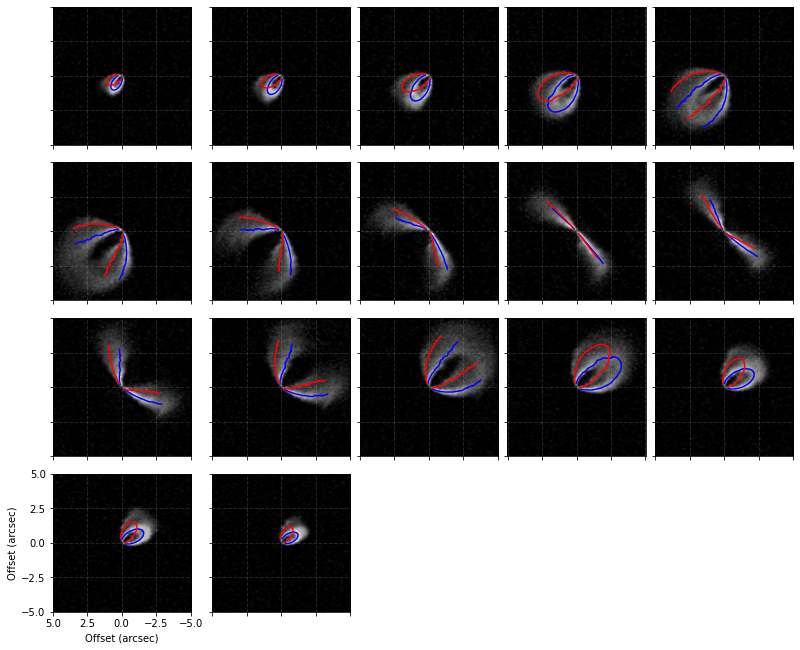

In [14]:
cube.plot_isovelocities(surface=surface, mstar=2.0, dist=101.0, vlsr=5.7e3, side='both')

Finally, we can also use the peak intensity, converted to a brightness temperature in Kelvin using the full Planck function (which depends on the beam size, hence the reason this function requires `observation` to run), to estimate the gas temperature structure. Note that for the brightness temperatures to truely represent the gas temperatures the lines must be optically thick and the continuum emission must also be included. See [Weaver et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..113W/abstract) for more details.

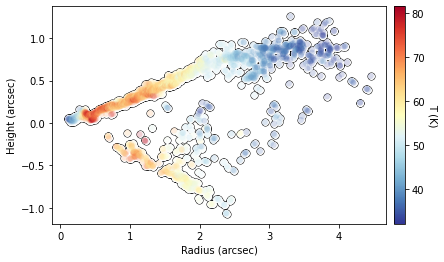

In [15]:
fig = cube.plot_temperature(surface=surface)

We can also fit an exponentially tapered powerlaw surface of the form, 

$$z(r) = z_0 \, \left( \frac{r - r_{\rm cavity}}{r_0} \right)^{\psi} \times \, \exp \left( -\left[ \frac{r - r_{\rm cavity}}{r_{\rm taper}} \right]^{q_{\rm taper}} \right),$$

where $r_0$, $z_0$ and $\psi$ describe the powerlaw function, $r_{\rm taper}$ and $q_{\rm taper}$ describe the exponential taper, and $r_{\rm cavity}$ allows for any inner cavity. This is the analytical form that is used by default within `GoFish` and demonstrated in the figure below.

![Analytical Emission Surface](analytical_form.png)

There are two methods to fit this surface: `fit_mission_surface` which uses `scipy.optimize.curve_fit`, or `fit_emission_surface_MCMC` which wraps [emcee](https://emcee.readthedocs.io/en/stable/), the  Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler. Both work in a very similar way. By default, these functions fit the emission surface in units of arcseconds, unless the source distance, `dist`, is specified in parsecs, which converts all distances to au. The reference radius, $r_0$, defaults to $1^{\prime\prime}$ or $100~{\rm au}$ depending on which units are being used, but this can be changed through the `r0` argument.

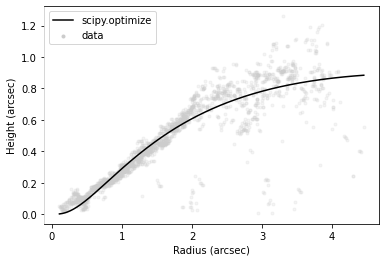

In [16]:
# plot the surface
fig = surface.plot_surface(side='front', return_fig=True)

# set the blue points to gray
for i in range(3):
    fig.axes[0].get_children()[i].set_facecolor('0.8')
    fig.axes[0].get_children()[i].set_edgecolor('0.8')
fig.axes[0].get_children()[1].set_label('data')

# fit an exponentitally tapered power law model and plot
r_mod, z_mod = surface.fit_emission_surface(side='front', return_model=True,
                                            tapered_powerlaw=True,
                                            include_cavity=False)
fig.axes[0].plot(r_mod, z_mod, color='k', lw=1.5, label='scipy.optimize')

# update legend
fig.axes[0].legend()